# National Oceanic and Atmospheric Administration (NOAA)
This jupyter notebook is meant to be used along with the North American Mesoscale Forecast System (NAM) dataset.  
This dataset can be found online under "Data Access > Model > Datasets > NAM" on the NOAA website.  
Once the data has been properly requested, confirmed, and processed using NOAA's Order Data feature,  
the requester is given 5 days to download the data via a email-link.  

# NAM 2017
To be more specific, the range this notebook will be targetting is the entire 2017 year (1800 UTC only). (100 ish Gb)  
Through further observation of the email-link provided by NOAA, it can be seen that the files end in an extension ".tar".  
These are all just zipped files. BEWARE- unpacking all these files doubles the 100Gb to 200Gb.  
It is recommended to make a main folder (moddata) with subfolders with each month on them (01, 02, 03, ..., 12).  
Then, putting all the corresponding ".tar" files in their respective month folder. The idea is to unpack an entire month and then delete the ".tar" files for that month. That way you don't have to unpack 100Gb to 200Gb and then try to delete 100Gb. It will be more like unpacking 6Gb to 12Gb then deleting the .tar files to regain space.

# Unpacking ".tar" Files
The ".tar" file names should look like the following:

namanl_218_2017010118.g2.tar

The format is very simple: namanl_218_yyyymmddhh.g2.tar  
Where yyyy = year, mm = month, dd = day, hh = hour (UTC)  
The above file would then be of 2017 January 1st 18 UTC

Since this data ranges accross the entire North America continent, 18 UTC was chosen. In New York, 18 UTC translates to 2 P.M. This makes any "real images" from the dataset appear more visually appealing since that part of the Earth will be facing towards the sun. This would be better than "real images" of NA taken at night. This also saves a lot of space. Imagine simply having 2 timestamps per day instead of 1, this would easily double the size of the data. NOAA allows 4 timestamps per day (0 UTC, 6 UTC, 12 UTC, and 18 UTC).  

Once you're inside the month directory containing all the ".tar" files for that month, simply use the following command to unpack:

// assuming path /moddata/01 being the path to all of january's ".tar" files type  
// and that you are currently inside the /01 directory, type the following into the kernel:  
for f in *.tar; do tar -xvf $f; done

This command should run for about 20 seconds and you should see all the files being unpacked individually.  
For every ".tar" file unpacked, there should be 5 ".grb2" files

// now type the following command to delete all of the ".tar" files in that directory:  
rm -r *.tar

This is done for all 12 months until every subdirectory of /moddata contains only ".grb2" files.  
The new file format should be:

nam_218_20170101_1800_000.grb2

nam_218_yyyymmdd_hhhh_band.grb2

# Congratulations!
Once all of the ".grb2" for every month are neatly organized in their own folder, the Exploritory Data Analysis can begin!  
These files can be viewed using a python package called "pygrib".

If you have anaconda installed, simply use:  
conda install -c conda-forge pygrib

That's about it for installations. Now let's dive into the code--

In [1]:
import pygrib # used to view ".grb2" files
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
%matplotlib inline

In [2]:
def print_grbs(filepath):
    """
    filepath: only 1 file path, not a list
    this function displays all the meta-data for the given filepath
    """
    grbs = pygrib.open(filepath)
    for grb in grbs:
        print(grb)
    grbs.close()

In [3]:
def get_paths(filepath, year = 0, month = 0, band = 0, everything = 0):
    """
    filepath: a string containing the file path to the directory containing all the .grb2 files
    year: specific year
    month: specific month
    band: specific band
    everything: if it is 1, then this function returns the entire list of filepaths available
    """
    if (everything != 0):
        years = [2017]
        months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
        month_days = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
        bands = [0, 1, 2, 3, 6]
        lst = []
        for month in months:
            for day in range(1, month_days[month - 1] + 1):
                for year in years:
                    for band in bands:
                        if (month < 10 and day < 10):
                            lst.append(filepath + "/nam_218_" + str(year) + "0" + str(month) + "0" + str(day) + "_1800_00" + str(band) + ".grb2")
                        elif (month < 10 and day >= 10):
                            lst.append(filepath + "/nam_218_" + str(year) + "0" + str(month) + str(day) + "_1800_00" + str(band) + ".grb2")
                        elif (month >= 10 and day < 10):
                            lst.append(filepath + "/nam_218_" + str(year) + str(month) + "0" + str(day) + "_1800_00" + str(band) + ".grb2")
                        else:
                            lst.append(filepath + "/nam_218_" + str(year) + str(month) + str(day) + "_1800_00" + str(band) + ".grb2")
        return lst
    else:
        month_days = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
        lst = []
        for day in range(1,month_days[month - 1] + 1):
            if (month < 10 and day < 10):
                lst.append(filepath + "/nam_218_" + str(year) + "0" + str(month) + "0" + str(day) +"_1800_00" + str(band) + ".grb2")
            elif (month < 10 and day >= 10):
                lst.append(filepath + "/nam_218_" + str(year) + "0" + str(month) + str(day) +"_1800_00" + str(band) + ".grb2")
            elif (month >= 10 and day < 10):
                lst.append(filepath + "/nam_218_" + str(year) + str(month) + "0" + str(day) +"_1800_00" + str(band) + ".grb2")
            else:
                lst.append(filepath + "/nam_218_" + str(year) + str(month) + str(day) +"_1800_00" + str(band) + ".grb2")
        return lst

# Some Useful Indexes
339: temperature at the surface (K)  
340: soil temperature between 0.0-0.1m (K)  
341: soil moisture content between 0.0-0.1m (proportion)  
342: soil liquid content between 0.0-0.1m (porportion)
343: soil temperature between 0.1-0.4m (K)  
344: soil moisture content between 0.1-0.4m (proportion)  
345: soil liquid content between 0.1-0.4m (porportion)  
346: soil temperature between 0.4-1m (K)  
347: soil moisture content between 0.4-1m (proportion)  
348: soil liquid content between 0.4-1m (porportion)  
349: soil temperature between 1-2m (K)  
350: soil moisture content between 1-2m (proportion)  
351: soil liquid content between 1-2m (porportion)  
352: soil temperature at 3m (K)  
355: plant surface water (kg^m-2)  
356: water equivilant of accumulated snow depth (kg^m-2)  
357: snow cover (%)  
358: snow depth (m)  
360: soil porosity (proportion)
361: temperature at 2m above ground (K)  
362: specific humidity at 2m above ground (kg kg^-1)  
363: dew point temperature at 2m above ground (K)  
364: relative humidity at 2m above ground (%)  
367: total precipitation (kg m^-2)
368: convective precipitation (kg m^-2)  
371: Categorical snow  
372: Categorical ice pellets  
373: Categorical freezing rain  
374: Categorical rain  
375: Surface roughness (m)  
378: Vegetation (%)  
379: Vegetation Type (Integer(0-13))  
380: Soil type  
388: Geopotential Height (gpm)  
436: Lightning  
437: Land-sea mask:(0 - 1)  
438: Sea-ice cover:(0 - 1)  
442: Total Cloud Cover (%)  

# A list of all the possible filepaths

In [ ]:
filepath = "/media/sf_moddata/2017"
all_paths = get_paths(filepath, everything = 1)
print(all_paths[0]) # 2017 january 31 18 utc band 0
print(all_paths[-1]) # 2017 december 31 18 utc band 6
print(len(all_paths)) # 365 days * 5 bands per day = 1825

# A list of all december file paths of band 0

In [ ]:
dec_paths = get_paths(filepath, 2017, 12, 0)
print(dec_paths[0]) # december 1
print(dec_paths[-1]) # december 31
print(len(dec_paths)) # 31 days * 1 band per day = 31

# Getting the surface temperature of december 1st

In [ ]:
dec_1_temp_surf = get_data(dec_paths[0], 339)
print(dec_1_temp_surf)

# Getting the surface temperature of the entire month of december

In [ ]:
dec_temp_surf = get_data(dec_paths, 339, everything = 1)
print(dec_temp_surf)

# Visualizing the data

In [ ]:
# lets try printing some of this data
rex = sns.heatmap(dec_1_temp_surf, cbar='true')
rex.invert_yaxis() # heatmap would print it upside down if it wasn't for this
print(np.max(dec_1_temp_surf))

# Grid Scaling for NAM
http://www.nco.ncep.noaa.gov/pmb/docs/on388/tableb.html#GRID218  
https://jswhit.github.io/pygrib/docs/

# NAIVE BAYES CLASSIFIER

The code below tries to classify the surface temperature from 31N-41N, 82W-102W  
of june 1st band 0 and dec 1st band 0  

since the amount of data is just 2 days, it's not that hard to classify

In [8]:
def get_data(path, select, year, month, band, index=0):
    """
    path: a string containing the path to the file where all the ".grb2" data is stores
    index: an integer, the type of data to be extracted (see list)
    year, month, band: an integer
    this function opens every file for the specified month
    it extracts, and crops the data to 31N-41N, 82W-102W
    returns a 2D numpy array, the rows = days of the month, the cols = the data for that specific day
    """
    if (month == 1 or month == 3 or month == 5 or month == 7 or month == 8 or month == 10 or month == 12):
        day = 31
    elif (month == 4 or month == 6 or month == 9 or month == 11):
        day = 30
    else:
        day = 28
    paths = get_paths(path, year, month, band)
    data = np.empty([day,13999]) # 13999, magic number from .data() function
    for i, path in enumerate(paths):
        grbs = pygrib.open(path) # opening file
        grb = grbs.select(name=select)[index] # getting specific data
        data_temp, lats, lons = grb.data(lat1=31,lat2=41,lon1=-102,lon2=-82) # 31N-41N, 82W-102W extracting
        data[i] = data_temp
        grbs.close() # closing file
        print(month, i+1)
    return data

# JUNE 1st vs DECEMBER 1st

In [6]:
import pygrib
import numpy as np
from sklearn.naive_bayes import GaussianNB

# JUNE
jun_1_path = "/media/sf_moddata/2017/nam_218_20170601_1800_000.grb2" # june 1st 2017
grbs_jun_1 = pygrib.open(jun_1_path)
grb_jun_1 = grbs_jun_1.select(name='Temperature')[39] # surface temperature
data_jun_1, lats_jun_1, lons_jun_1 = grb_jun_1.data(lat1=31,lat2=41,lon1=-102,lon2=-82) # 31N-41N, 82W-102W
print("June: ", data_jun_1.shape, lats_jun_1.shape, lons_jun_1.shape)
grbs_jun_1.close()

# DECEMBER
dec_1_path = "/media/sf_moddata/2017/nam_218_20171201_1800_000.grb2" # december 1st 2017
grbs_dec_1 = pygrib.open(dec_1_path)
grb_dec_1 = grbs_dec_1.select(name='Temperature')[39] # surface temperature
data_dec_1, lats_dec_1, lons_dec_1 = grb_dec_1.data(lat1=31,lat2=41,lon1=-102,lon2=-82) # 31N-41N, 82W-102W
print("December: ", data_dec_1.shape, lats_dec_1.shape, lons_dec_1.shape)
grbs_dec_1.close()

# STACKING DATA
data = np.stack((data_jun_1, data_dec_1))
print("Stacked June and December: ", data.shape)

# TARGET ARRAY
target = np.array([0,1])
print("Target: ", target.shape)
# NAIVE BAYES
gnb = GaussianNB()
y_pred = gnb.fit(data, target).predict(data)
print("Number of mislabeled points out of a total %d points : %d" % (data.shape[0],(target != y_pred).sum()))

June:  (13999,) (13999,) (13999,)
December:  (13999,) (13999,) (13999,)
Stacked June and December:  (2, 13999)
Target:  (2,)
Number of mislabeled points out of a total 2 points : 0


# JUNE VS DECEMBER

In [9]:
import pygrib
import numpy as np
from sklearn.naive_bayes import GaussianNB

path = "/media/sf_moddata/2017"

data_jun = get_data(path, "Temperature", 2017, 6, 0, 39) # "Temperature" and index 39 is soil temperature
print("June: ", data_jun.shape)
data_dec = get_data(path, "Temperature", 2017, 12, 0, 39) # "Temperature" and index 39 is soil temperature
print("December: ", data_dec.shape)

# STACKING DATA
data = np.vstack((data_jun, data_dec))
print(data.shape)

# TARGET ARRAY
target = np.empty(len(data))
for i in range(len(target)):
    if (i < 30):
        target[i] = 0 # june
    else:
        target[i] = 1 # december
print(target)

# NAIVE BAYES
gnb = GaussianNB()
y_pred = gnb.fit(data, target).predict(data)
print("Number of mislabeled points out of a total %d points : %d" % (data.shape[0],(target != y_pred).sum()))

6 1
6 2
6 3
6 4
6 5
6 6
6 7
6 8
6 9
6 10
6 11
6 12
6 13
6 14
6 15
6 16
6 17
6 18
6 19
6 20
6 21
6 22
6 23
6 24
6 25
6 26
6 27
6 28
6 29
6 30
June:  (30, 13999)
12 1
12 2
12 3
12 4
12 5
12 6
12 7
12 8
12 9
12 10
12 11
12 12
12 13
12 14
12 15
12 16
12 17
12 18
12 19
12 20
12 21
12 22
12 23
12 24
12 25
12 26
12 27
12 28
12 29
12 30
12 31
December:  (31, 13999)
(61, 13999)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Number of mislabeled points out of a total 61 points : 0


In [ ]:
rex = sns.heatmap(data, cbar = 'true')
rex.invert_yaxis()

In [10]:
import pygrib
import numpy as np
from sklearn.naive_bayes import GaussianNB

path = "/media/sf_moddata/2017"

data_nov = get_data(path, "Temperature", 2017, 11, 0, 39) # "Temperature" and index 39 is soil temperature
print("Nov: ", data_nov.shape)
data_dec = get_data(path, "Temperature", 2017, 12, 0, 39) # "Temperature" and index 39 is soil temperature
print("December: ", data_dec.shape)

# STACKING DATA
data = np.vstack((data_nov, data_dec))
print(data.shape)

# TARGET ARRAY
target = np.empty(len(data))
for i in range(len(target)):
    if (i < 30):
        target[i] = 0 # june
    else:
        target[i] = 1 # december
print(target)

# NAIVE BAYES
gnb = GaussianNB()
y_pred = gnb.fit(data, target).predict(data)
print("Number of mislabeled points out of a total %d points : %d" % (data.shape[0],(target != y_pred).sum()))

11 1
11 2
11 3
11 4
11 5
11 6
11 7
11 8
11 9
11 10
11 11
11 12
11 13
11 14
11 15
11 16
11 17
11 18
11 19
11 20
11 21
11 22
11 23
11 24
11 25
11 26
11 27
11 28
11 29
11 30
Nov:  (30, 13999)
12 1
12 2
12 3
12 4
12 5
12 6
12 7
12 8
12 9
12 10
12 11
12 12
12 13
12 14
12 15
12 16
12 17
12 18
12 19
12 20
12 21
12 22
12 23
12 24
12 25
12 26
12 27
12 28
12 29
12 30
12 31
December:  (31, 13999)
(61, 13999)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Number of mislabeled points out of a total 61 points : 7


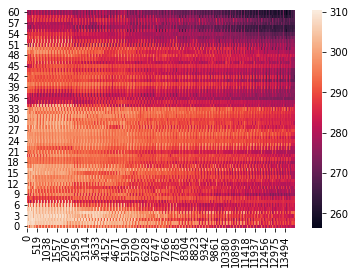

In [11]:
rex = sns.heatmap(data, cbar = 'true')
rex.invert_yaxis()

# NAIVE BAYES CLASSIFIER FOR ENTIRE YEAR

In [ ]:
def get_data_range(path, select, year, month_start, month_end, band, index = 0):
    """
    path: a string containing the path to the file where all the ".grb2" data is stores
    select: a string, the type of data to be extracted (see list)
    year, month_start, month_end band: an integer
    this function opens every file for the specified month range
    it extracts, and crops the data to 31N-41N, 82W-102W
    returns a 2D numpy array, the rows = days of the month, the cols = the data for that specific day
    """
    lst = []
    for i in range(month_start, month_end+1):
        lst.append(get_data(path, select, year, i, band, index))
    temp = np.vstack((lst[0], lst[1]))
    temp1 = temp
    for i in range(2, len(lst)):
        data_blah = np.vstack((temp1, lst[i]))
        temp1 = data
    return temp1

In [ ]:
def get_target_year():
    """
    this function returns an array that labels every day in a year with the corresponding month
    """
    target = np.empty(365)
    for i in range(365):
        if (i < 31):
            target[i] = 1 # jan
        elif (i < 59):
            target[i] = 2 # feb
        elif (i < 90):
            target[i] = 3 # mar
        elif (i < 120):
            target[i] = 4 # apr
        elif (i < 151):
            target[i] = 5 # may
        elif (i < 181):
            target[i] = 6 # jun
        elif (i < 212):
            target[i] = 7 # jul
        elif (i < 243):
            target[i] = 8 # aug
        elif (i < 273):
            target[i] = 9 # sep
        elif (i < 304):
            target[i] = 10 # oct
        elif (i < 334):
            target[i] = 11 # nov
        else:
            target[i] = 12 # dec
    return target

In [ ]:
path = "/media/sf_moddata/2017"
data = get_data(path, "Temperature", 2017, 1, 0, 39)
rex = sns.heatmap(data, cbar='true')
rex.invert_yaxis()
#target = get_target_year()
# NAIVE BAYES
#gnb = GaussianNB()
#y_pred = gnb.fit(data, target).predict(data)
#print("Number of mislabeled points out of a total %d points : %d" % (data.shape[0],(target != y_pred).sum()))
#rex = sns.heatmap(data, cbar='true')
#rex.invert_yaxis()

In [ ]:
(188/365)

In [ ]:
rex = sns.heatmap(data, cbar='true')
rex.invert_yaxis()

In [ ]:
plt.imshow(data, origin='lower')

In [ ]:
max_data = np.empty(len(data))

In [ ]:
count = 0
for i in data:
    max_data[count] = np.max(i)
    count = count + 1
print(max_data.shape, target.shape)

In [ ]:
# NAIVE BAYES
gnb = GaussianNB()
y_pred = gnb.fit(max_data.reshape(-1,1), target).predict(max_data.reshape(-1,1))
print("Number of mislabeled points out of a total %d points : %d" % (max_data.shape[0],(target != y_pred).sum()))

In [ ]:
from sklearn.cluster import KMeans
k_means = KMeans(init='k-means++', n_clusters=3, n_init=10)
k_means.fit(data)

In [ ]:
path = "/media/sf_moddata/2017/nam_218_20170101_1800_000.grb2"
print_grbs(path)